In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np

from torch.utils.data import DataLoader
import torchvision.transforms as tt

import matplotlib.pyplot as plt
import matplotlib

In [2]:
BATCH_SIZE = 64
N_EPOCHS   = 100
N_TIMES = 10

DATA_PATH = '../datasets/MNIST/'
Z_DIM = 2

In [3]:
class VAE(nn.Module):
    def __init__(self, D, d = Z_DIM):
        super(VAE, self).__init__()
        self.encoder = Encoder(d, D)
        self.decoder = Decoder(d, D)
        
        #d - for latent space
        #D - for kernel space
        self.d = d
        self.D = D
        
    def count_vlb(self, X, i):
        #get parameters of z distribution
        mu_z, var_z = self.encoder(X)

        #sample latent(mu_z, var_z)
        z = Normal(torch.zeros(mu_z.size()), torch.ones(mu_z.size())).sample()
        z = mu_z + torch.sqrt(var_z) * nn.Parameter(z, requires_grad=False).to(device)
        
        latent_loss = 0.5 * (var_z + mu_z**2 - torch.log(var_z+1e-12) - 1).mean(dim=0).sum()
        
        #get parameters of x_hat distribution
        mu_x, var_x = self.decoder(z)
        normal = Normal(mu_x, torch.sqrt(var_x))
        reconstruction_loss = normal.log_prob(X).mean(dim=0).sum()
        
        #minus since default optimizers minimize loss
        return -(reconstruction_loss - latent_loss), latent_loss, reconstruction_loss
                   
    def generate_samples(self, num_samples):
        z = torch.FloatTensor(np.random.normal(0, 1, size=[num_samples, self.d, 1, 1])).to(device)
        return self.decoder(z)

In [4]:
class Encoder(nn.Module):
    def __init__(self, d, D):
        super(Encoder, self).__init__()
        self.D = D
        self.d = d
        
        self.seq = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0)
        )
        
        self.fc_mu = nn.Conv2d(64, Z_DIM, kernel_size=(1, 1), stride=(1, 1))
        self.fc_var = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1)),
            nn.Softplus()
        )
        
    def forward(self, X):
        X = self.seq(X)
        
        mu = self.fc_mu(X)
        var = self.fc_var(X)
        
        return mu, var

In [5]:
class Decoder(nn.Module):
    def __init__(self, d, D):
        super(Decoder, self).__init__()
        self.D = D
        self.d = d
        
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(Z_DIM, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0)
        )
        self.fc_mu = nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
        self.fc_var = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1)),
            nn.Softplus()
        )
        
    def forward(self, X):
        X = self.seq(X)
        
        mu = self.fc_mu(X)
        var = self.fc_var(X)
        
        return mu, var

In [6]:
device='cuda'
vae = VAE(49).to(device)
vae.load_state_dict(torch.load("vae_weights.pth"))

In [7]:
#load MNIST and transform data to tensor
trans = tt.Compose([tt.ToTensor()]) 

train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True,  transform=trans, download=False) 
test_dataset  = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_loader  = DataLoader(dataset=test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

In [8]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(BATCH_SIZE, -1)

In [9]:
class FConvMNIST(nn.Module):
    def __init__(self):
        super(FConvMNIST, self).__init__()
        
        self.conv1   = nn.Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
        self.relu    = nn.LeakyReLU(negative_slope=0.01)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2   = nn.Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1))
        self.flat    = Flatten()
        self.clf     = nn.Linear(in_features=1152, out_features=10, bias=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        return self.clf(self.flat(x)) 

In [10]:
model = FConvMNIST().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
#init weight of the model with samples from vae
print("1", model.conv1.weight[0])
model.conv1.weight = nn.Parameter(vae.generate_samples(32)[0])
print("2", model.conv1.weight[0])

1 tensor([[[-0.0356,  0.0978, -0.0737,  0.0705,  0.1203,  0.0370,  0.0920],
         [-0.0601,  0.1051,  0.0111, -0.0678, -0.0777, -0.1013,  0.0734],
         [ 0.0923,  0.0989, -0.0897, -0.0385, -0.0651,  0.0739,  0.1212],
         [-0.0101, -0.1166, -0.0300, -0.1351,  0.0699,  0.0103, -0.1002],
         [ 0.0930,  0.1244, -0.1297, -0.0319, -0.0926,  0.0665, -0.0851],
         [-0.0166, -0.0750, -0.1383, -0.1172,  0.0592,  0.0979, -0.0634],
         [ 0.0774,  0.0009, -0.0230, -0.1380,  0.1016,  0.1220,  0.0112]]],
       device='cuda:0', grad_fn=<SelectBackward>)
2 tensor([[[ 3.2607e-02,  3.7467e-02,  2.1381e-02,  1.8802e-02,  5.8605e-03,
          -2.9485e-02, -5.8205e-02],
         [ 1.0078e-02,  1.8295e-02,  1.2551e-04, -3.8441e-03, -2.2387e-02,
          -5.3566e-02, -6.8741e-02],
         [ 3.4360e-03, -2.8978e-03, -1.4809e-02, -3.6315e-02, -5.0455e-02,
          -6.7407e-02, -5.0183e-02],
         [ 1.1813e-02, -4.2189e-03, -4.1511e-02, -6.3111e-02, -6.1534e-02,
          -5.58

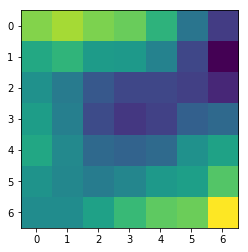

In [12]:
mu_x = model.conv1.weight.detach().cpu().numpy()
plt.imshow(mu_x[4].reshape((7, 7)))

In [13]:
#lists that will help to average data about accuracy
vae_acc = []
vanilla_acc = []

In [14]:
for i in range(N_TIMES):
    model = FConvMNIST().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    model.conv1.weight = nn.Parameter(vae.generate_samples(32)[0])
    
    loss_list = []
    acc_list  = []
    test_acc_list = []

    N_STEPS = len(train_loader)

    viewed_batches = 0
    #train network
    for j in range(N_EPOCHS):
        for k, (images, labels) in enumerate(train_loader):
            if (images.shape[0] < BATCH_SIZE):
                    break
            #forward
            labels = labels.to(device)
            pred = model(images.to(device))
            loss = criterion(pred, labels)
            loss_list.append(loss.item())

            #backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            viewed_batches += 1

#             if viewed_batches % 50 == 0:
#                 print("samples ", viewed_batches * BATCH_SIZE)

            #statictics
            total = labels.size(0)
            _, predicted = torch.max(pred.data, 1)

            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            test_acc = []
            for i, (test_images, test_labels) in enumerate(test_loader):
                if (test_images.shape[0] < BATCH_SIZE):
                    break
                test_labels = test_labels.to(device)
                pred = model(test_images.to(device))

                #statictics
                total = test_labels.size(0)
                _, predicted = torch.max(pred.data, 1)

                correct = (predicted == test_labels).sum().item()
                test_acc.append(correct / total)

            test_acc_list.append(np.mean(test_acc))

            if viewed_batches == 100:
                break
        if viewed_batches == 100:
            break
            
    vae_acc.append(test_acc_list)


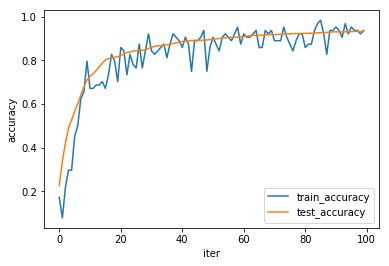

In [15]:
plt.figure()
plt.plot([i for i in range(len(acc_list))], acc_list, label = 'train_accuracy')
plt.plot([i for i in range(len(vae_acc[0]))], np.mean(vae_acc, axis = 0), label = 'test_accuracy')

plt.xlabel('iter')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [16]:
#now train models without initizialisation with vae samples
for i in range(N_TIMES):
    model = FConvMNIST().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    vanilla_loss_list = []
    vanilla_acc_list  = []
    vanilla_test_acc_list = []

    N_STEPS = len(train_loader)
    print(N_STEPS)
    viewed_batches = 0
    #train network
    for j in range(N_EPOCHS):
        for k, (images, labels) in enumerate(train_loader):
            if (images.shape[0] < BATCH_SIZE):
                    break
            #forward
            labels = labels.to(device)
            pred = model(images.to(device))
            loss = criterion(pred, labels)
            vanilla_loss_list.append(loss.item())

            #backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            viewed_batches += 1

#             if viewed_batches % 50 == 0:
#                 print("samples ", viewed_batches * BATCH_SIZE)

            #statictics
            total = labels.size(0)
            _, predicted = torch.max(pred.data, 1)

            correct = (predicted == labels).sum().item()
            vanilla_acc_list.append(correct / total)

            vanilla_test = []
            for i, (test_images, test_labels) in enumerate(test_loader):
                if (i > 20 or test_images.shape[0] < BATCH_SIZE):
                    break
                test_labels = test_labels.to(device)
                pred = model(test_images.to(device))
                optimizer.step()

                #statictics
                total = test_labels.size(0)
                _, predicted = torch.max(pred.data, 1)

                correct = (predicted == test_labels).sum().item()
                vanilla_test.append(correct / total)

            vanilla_test_acc_list.append(np.mean(vanilla_test))

            if viewed_batches == 100:
                break
        if viewed_batches == 100:
            break
            
    vanilla_acc.append(vanilla_test_acc_list)

938
938
938
938
938
938
938
938
938
938


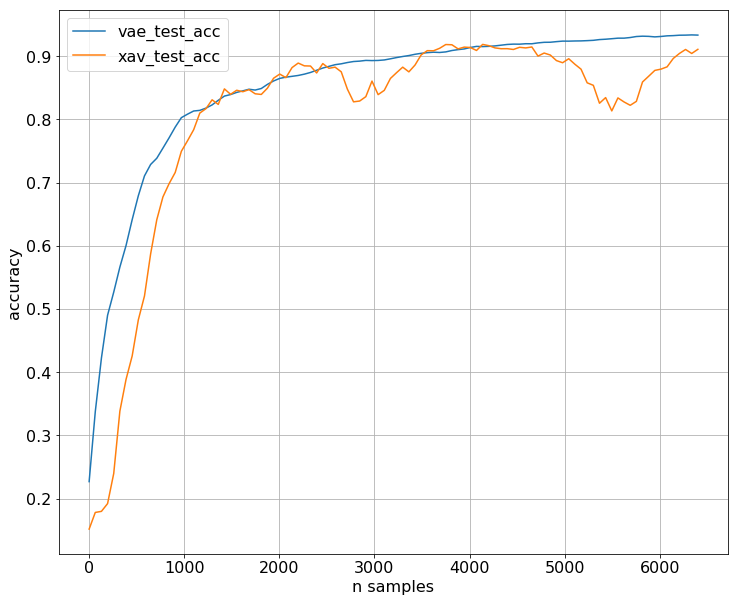

In [17]:
plt.figure(figsize=(12, 10))
matplotlib.rcParams.update({'font.size': 16})

#plot dependency accuracy on test from size of train dataset
plt.plot(np.linspace(0, 6400, len(np.mean(vae_acc, axis = 0))), np.mean(vae_acc, axis = 0), label = 'vae_test_acc')
plt.plot(np.linspace(0, 6400, len(np.mean(vae_acc, axis = 0))), np.mean(vanilla_acc, axis = 0), label = 'xav_test_acc')

plt.xlabel('n samples')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()